<a href="https://colab.research.google.com/github/thuvarahan97/Pump-it-Up---Driven-Data/blob/main/PumpItUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# pip install catboost

In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [247]:
def freq_enc(df,cols):
    for col in cols:
        df[col] = df[col].map(df[col].value_counts().to_dict())/len(df)
    return df

In [248]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [249]:
dir = '/content/drive/My Drive/In17-S7-CS4622 - Machine Learning - 170643M/Pump It Up - Driven Data Challenge/'

In [250]:
# loading data files
train_set = pd.read_csv(dir + 'training_set_values.csv', parse_dates=True)
train_label = pd.read_csv(dir + 'training_set_labels.csv')
test_set = pd.read_csv(dir + 'test_set_values.csv', parse_dates=True)
submission = pd.read_csv(dir + 'submission_format.csv')

In [251]:
# make copy of dataset
test_copy = test_set.copy()
train_copy = train_set.copy()

In [252]:
# displaying training dataset
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [253]:
train_set.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [254]:
# displaying test dataset
test_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [255]:
test_set.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,21359.364833,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,10.000000,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18727.000000,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37361.500000,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [256]:
# displaying training labels
y = train_label['status_group'].values
train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [257]:
# size of training dataset
train_set.shape

(59400, 40)

In [258]:
# size of test dataset
test_set.shape

(14850, 40)

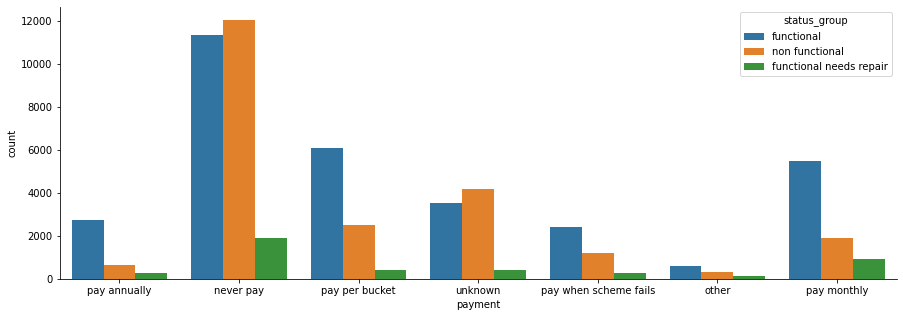

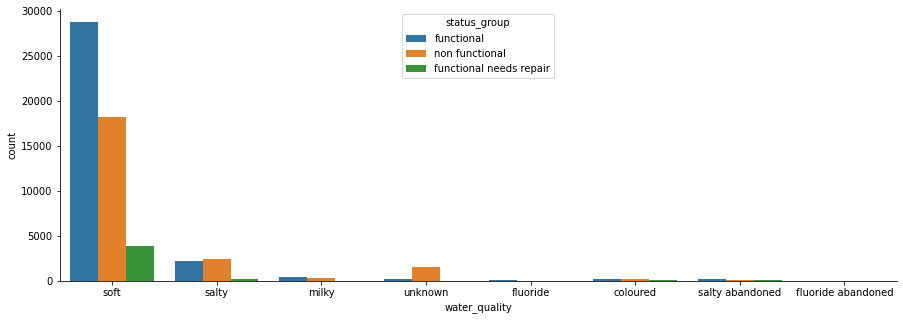

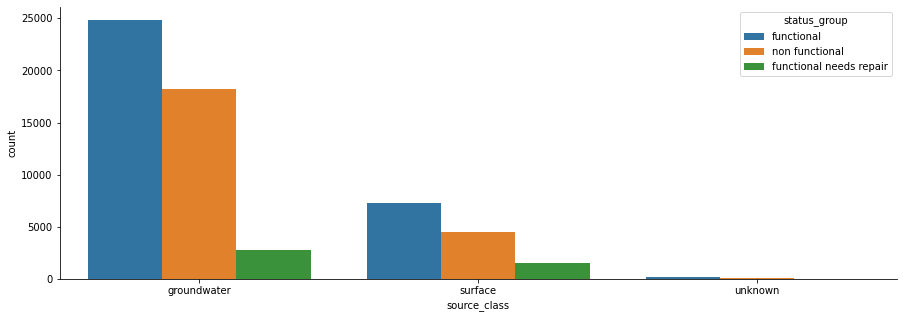

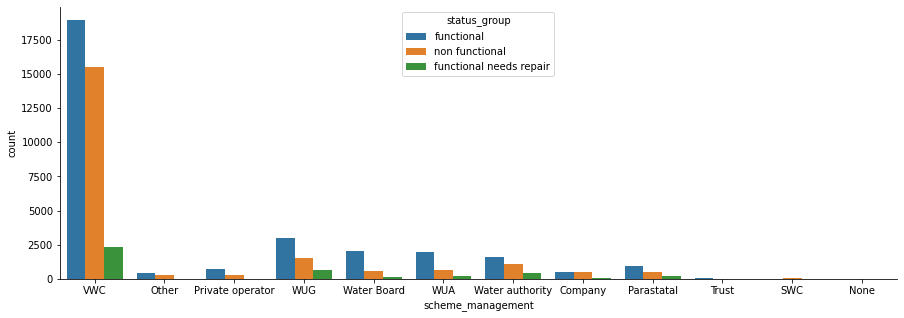

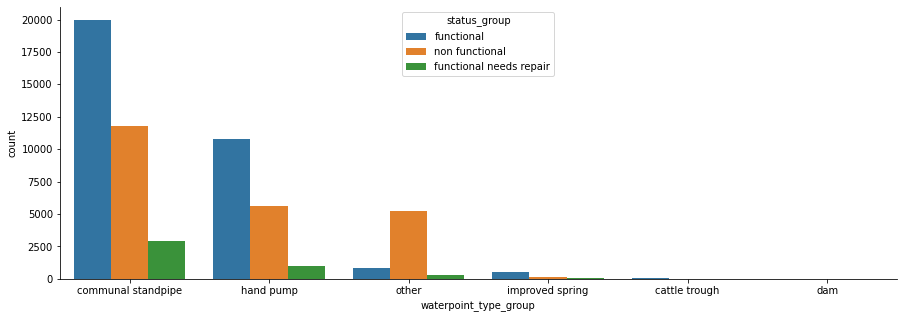

In [259]:
def plotDataGraph(x):
  # df2.plot.barh(stacked=True);
  temp = train_set.copy()
  temp['status_group'] = y
  # temp = temp.groupby(['status_group', x]).size().reset_index().pivot(columns='status_group', index=x)
  fig, axs = plt.subplots(figsize=(15, 5))
  plot = sns.countplot(x=x, hue='status_group', data=temp)
  sns.despine()


plot_cols=['payment','water_quality','source_class','scheme_management','waterpoint_type_group']
for i in range(0, len(plot_cols)):
  plotDataGraph(plot_cols[i])

In [260]:
# Assign index to each dataset
train_set = train_set.set_index('id')
test_set = test_set.set_index('id')

In [261]:
# numeric_col = np.where(train_set.dtypes != object)[0]
# numeric_feat = [train_set.columns[x] for x in numeric_col]

In [262]:
train_set['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Raurensia              1
MWAKI CONTRACTO        1
Village Office         1
CG/RC                  1
Mambe                  1
Name: installer, Length: 2145, dtype: int64

In [263]:
train_set['installer'] = train_set['installer'].str.lower().str.strip().str.split(" ", expand=True)[0].replace("/", "").replace("\\", "")

In [264]:
train_set['installer'].value_counts()

dwe           17407
government     1898
hesawa         1395
rwe            1223
district       1192
              ...  
sakwidi           1
mwl.mwita         1
mbulu             1
filber            1
villege           1
Name: installer, Length: 1528, dtype: int64

In [265]:
mask = train_set['installer'].map(train_set['installer'].value_counts()) < 100
train_set['installer'] =  train_set['installer'].mask(mask, 'other')
mask = test_set['installer'].map(test_set['installer'].value_counts()) < 100
test_set['installer'] =  test_set['installer'].mask(mask, 'other')

In [266]:
train_set['installer'].value_counts()

dwe           17407
other         10697
government     1898
hesawa         1395
rwe            1223
              ...  
muwsa           107
ded             105
wizara          104
oikos           101
hsw             100
Name: installer, Length: 77, dtype: int64

In [267]:
train_set['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Bukwang Church Saint         1
Norad/japan                  1
Long Ga                      1
Safari Camp                  1
Nyahale                      1
Name: funder, Length: 1897, dtype: int64

In [268]:
mask = train_set['funder'].map(train_set['funder'].value_counts()) < 100
train_set['funder'] =  train_set['funder'].mask(mask, 'other')
mask = test_set['funder'].map(test_set['funder'].value_counts()) < 100
test_set['funder'] =  test_set['funder'].mask(mask, 'other')

In [269]:
train_set['funder'].value_counts()

other                            12379
Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
                                 ...  
Village Council                    105
Ru                                 105
Halmashauri Ya Wilaya Sikonge      102
Germany                            101
Hsw                                101
Name: funder, Length: 92, dtype: int64

In [270]:
# Find the count of null values in train_data
train_set.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [271]:
# Find the count of null values in test_data
test_set.isnull().sum()

amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_g

In [272]:
# Find the missing data
def findMissingData(data, title):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missingdata=pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    missingdata= missingdata[missingdata["Percentage"] > 0]

    plt.subplots(figsize=(15,5))
    sns.barplot(missingdata.index, missingdata["Percentage"])
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Feature vs. Percentage of missing data in ' + title, fontsize=14)
    
    return missingdata

Missing values in Train Data
Missing values in Test Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Total,Percentage
scheme_name,7092,47.757576
scheme_management,969,6.525253
installer,877,5.905724
funder,869,5.851852
public_meeting,821,5.528620
permit,737,4.962963
subvillage,99,0.666667


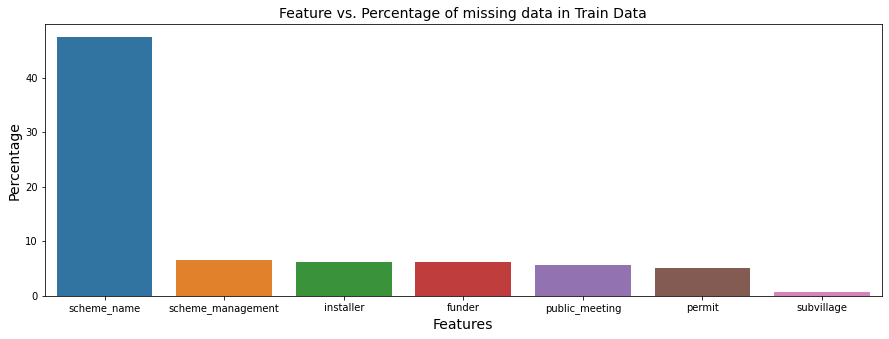

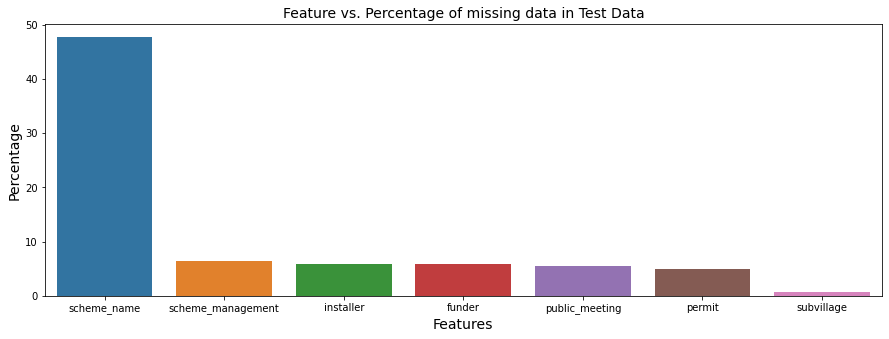

In [273]:
# Show missing values in train_data
print("Missing values in Train Data")
findMissingData(train_set, "Train Data")

# Show missing values in test_data
print("Missing values in Test Data")
findMissingData(test_set, "Test Data")

In [274]:
cols = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [275]:
transform_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 
                  'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 
                  'scheme_management', 'permit', 'extraction_type', 
                  'extraction_type_group', 'extraction_type_class', 'management',
                  'management_group', 'payment', 'payment_type', 'water_quality',
                  'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                  'source_class', 'waterpoint_type', 'waterpoint_type_group']

for x in range(len(transform_cols)):
  train_set[transform_cols[x]] = LabelEncoder().fit_transform(train_set[transform_cols[x]].astype(str).str.strip())
  test_set[transform_cols[x]] = LabelEncoder().fit_transform(test_set[transform_cols[x]].astype(str).str.strip())

In [276]:
# Drop "scheme_name" column in train_set and test_set
train_set.drop(['scheme_name'], axis=1, inplace = True)
test_set.drop(['scheme_name'], axis=1, inplace=True)

In [277]:
train_set['scheme_management'].fillna(train_set['scheme_management'].median(), inplace = True)
test_set['scheme_management'].fillna(test_set['scheme_management'].median(), inplace = True)

train_set['installer'].fillna(train_set['installer'].median(), inplace = True)
test_set['installer'].fillna(test_set['installer'].median(), inplace = True)

train_set['funder'].fillna(train_set['funder'].median(), inplace = True)
test_set['funder'].fillna(test_set['funder'].median(), inplace = True)

train_set['public_meeting'].fillna(train_set['public_meeting'].median(), inplace = True)
test_set['public_meeting'].fillna(test_set['public_meeting'].median(), inplace = True)

train_set['permit'].fillna(train_set['permit'].median(), inplace = True)
test_set['permit'].fillna(test_set['permit'].median(), inplace = True)

In [278]:
# # Combine train_set and test_set
# all_data = pd.concat([train_set, test_set], axis=0, sort=False)

In [279]:
train_set.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [280]:
# for col in cols:
#     train_set[col] = train_set[col].apply(str)
#     test_set[col] = test_set[col].apply(str)

In [281]:
# drop unwanted columns from train and test data
to_drop = ['date_recorded']

train_set = train_set.drop(to_drop,axis=1)
test_set = test_set.drop(to_drop,axis=1)

In [282]:
train_set['status_group'] = y

In [283]:
# X_train, X_test, y_train, y_test = train_test_split(df[factors], df_labels.status_group, test_size=0.1, random_state=10)

# print len(X_train), len(X_test)

In [284]:
X_train = train_set.drop('status_group',axis=1)
y_train = train_set['status_group']
test = test_set.copy()

In [285]:
# categorical = np.where(X.dtypes == object)[0];categorical

In [286]:
# skf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
# cat = CatBoostClassifier(iterations=500,random_state=42,reg_lambda=30,eval_metric='AUC',custom_loss='Logloss')
# pump_scores = []
# pump_pred= np.zeros(len(test))
# for fold, (train_index,test_index) in enumerate(skf.split(X,y)):
#     print(f'====================================== FOLD {fold} ======================================================')
#     X_train,X_test = X.iloc[train_index],X.iloc[test_index]
#     y_train,y_test = y.iloc[train_index],y.iloc[test_index]
#     cat.fit(X_train,y_train,early_stopping_rounds=500,eval_set=[(X_train,y_train),(X_test,y_test)],use_best_model=True,cat_features=categorical)
#     pump_scores.append(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))
#     pump_pred +=cat.predict_proba(test_A)[:,1]

In [287]:
# Decision Tree Classifier
modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [288]:
# Random Forest Classifier 
modelRFC = RandomForestClassifier(bootstrap=True,
                               criterion='gini',
                               min_impurity_decrease=0.0,
                               min_samples_leaf=1, 
                               min_samples_split=2,
                               n_estimators=1000, 
                               n_jobs=1,
                               oob_score=True,
                               random_state=0,
                              )

modelRFC.fit(X_train, y_train)

print("OOB Score: %.4f" % modelRFC.oob_score_)

accuracy = round(modelRFC.score(X_train, y_train) * 100, 2)
print("Accuracy: %.2f" % accuracy)

OOB Score: 0.8158
Accuracy: 100.00


In [289]:
X_pred = test_set
y_pred = modelRFC.predict(X_pred)

In [290]:
# assign predicted values to submission
submission['status_group'] = y_pred

In [291]:
submission.describe()

,id
count,14850.000000
mean,37161.972929
std,21359.364833
min,10.000000
25%,18727.000000
50%,37361.500000
75%,55799.750000
max,74249.000000


In [292]:
# submission correlation
submission.corr()

,id
id,1.0


In [293]:
# create csv from submission
submission.to_csv('submission.csv', index=False)

In [294]:
# download submission file
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>